In [174]:
import numpy as np 
import pandas as pd
from sklearn.cluster import KMeans
import csv
import math
import matplotlib.pyplot
from matplotlib import pyplot as plt
from sklearn.utils import shuffle

maxAcc = 0.0
maxIter = 0
C_Lambda = 0.03
TrainingPercent = 80
ValidationPercent = 10
TestPercent = 10
M = 10#5#10
PHI = []
IsSynthetic = False
IsConcat = True
humanDataSampleSize=791
gscDataSampleSize=50000
humanFeaturesFile='HumanObserved-Features-Data.csv'
humanSamePairFile='same_pairs.csv'
humanDiffPairFile='diffn_pairs.csv'
gscFeatureFile = 'GSC-Features.csv'
gscSamePairFile='same_pairs_gsc.csv'
gscDiffPairFile='diffn_pairs_gsc.csv'

In [155]:
def processData(data,samePair,diffPair,sampleSize,isGSC):
    
    if(isGSC == False):
        data = pd.read_csv(data,index_col=0)
    else:
        data = pd.read_csv(data)


    samePair = pd.read_csv(samePair)


    diffPair = pd.read_csv(diffPair)


    merged1 = pd.merge(samePair, data, left_on = ['img_id_A'],right_on= ['img_id'],how = 'inner').drop(['img_id'], axis='columns')
    merged2 = pd.merge(samePair, data, left_on = ['img_id_B'],right_on= ['img_id'],how = 'inner').drop(['img_id','img_id_A','img_id_B','target'], axis='columns')

    merged3=pd.concat([merged1, merged2],axis=1)


    merged4=merged1 - merged2
    merged4=merged4.drop(['img_id_A','img_id_B','target'], axis='columns')
    merged4=pd.concat([merged4,merged1['target']],axis=1)



    diffmerged1 =pd.merge(diffPair, data, left_on = ['img_id_A'],right_on= ['img_id'],how = 'inner').drop(['img_id'], axis='columns')
    diffmerged2 = pd.merge(diffPair, data, left_on = ['img_id_B'],right_on= ['img_id'],how = 'inner').drop(['img_id','img_id_A','img_id_B','target'], axis='columns')


    diffmerged3=pd.concat([diffmerged1, diffmerged2],axis=1).sample(n=sampleSize)


    diffmerged4=diffmerged1 - diffmerged2
    diffmerged4=diffmerged4.drop(['img_id_A','img_id_B','target'], axis='columns')
    diffmerged4=pd.concat([diffmerged4,diffmerged1['target']],axis=1)
    diffmerged5=diffmerged4.sample(n=sampleSize).abs()


    if(isGSC == True):
        merged3=merged3.sample(n=sampleSize)
        subtractionFeatures=merged4.sample(n=sampleSize).abs()
    else:
        merged3=merged3
        subtractionFeatures=merged4.abs()

    concatFeatures=merged3.append(diffmerged3)    
    concatFeatures=shuffle(concatFeatures)
    print("Feature Concatenation:"+str(concatFeatures.shape))
    subtractionFeatures=subtractionFeatures.append(diffmerged5)
    subtractionFeatures=shuffle(subtractionFeatures)
    print("Feature Subtraction:"+str(subtractionFeatures.shape))
    return concatFeatures,subtractionFeatures

In [156]:
def GetTargetVector(features):

    target=features['target'].values.T.tolist()

    return target


def GenerateRawData(features,isConcat):
    
    features = features.loc[:, (features != 0).any(axis=0)]
    if(isConcat == True):
        dataMatrix = features.drop(columns=['img_id_A','img_id_B','target']).as_matrix()
    else:
        dataMatrix = features.drop(columns=['target']).as_matrix()
    dataMatrix = np.transpose(dataMatrix)
    #print (dataMatrix)

    return dataMatrix

def GenerateTrainingTarget(rawTraining,TrainingPercent = 80):
    TrainingLen = int(math.ceil(len(rawTraining)*(TrainingPercent*0.01)))
    t           = rawTraining[:TrainingLen]
    #print(str(TrainingPercent) + "% Training Target Generated..")
    return t


def GenerateTrainingDataMatrix(rawData, TrainingPercent = 80):
    T_len = int(math.ceil(len(rawData[0])*0.01*TrainingPercent))
    d2 = rawData[:,0:T_len]
    #print(str(TrainingPercent) + "% Training Data Generated..")
    return d2

def GenerateValData(rawData, ValPercent, TrainingCount): 
    valSize = int(math.ceil(len(rawData[0])*ValPercent*0.01))
    V_End = TrainingCount + valSize
    dataMatrix = rawData[:,TrainingCount+1:V_End]
    #print (str(ValPercent) + "% Val Data Generated..")  
    return dataMatrix

def GenerateValTargetVector(rawData, ValPercent, TrainingCount): 
    valSize = int(math.ceil(len(rawData)*ValPercent*0.01))
    #print(rawData)
    V_End = TrainingCount + valSize
    t =rawData[TrainingCount+1:V_End]
    #print (str(ValPercent) + "% Val Target Data Generated..")
    #print(t)
    return t

In [157]:
def generateFeatureData(isConcat,data,samePair,diffPair,sampleSize,isGSC):
    concatFeatures,subtractionFeatures = processData(data,samePair,diffPair,sampleSize,isGSC)
    return  concatFeatures,subtractionFeatures

def generateData(features,isConcat):
    RawTarget = GetTargetVector(features)
    RawData   = GenerateRawData(features,isConcat)

    
    
    
    return  RawTarget,RawData  

#Creating Training dataset
def createTrainingDataset(RawTarget,RawData):
    TrainingTarget = np.array(GenerateTrainingTarget(RawTarget,TrainingPercent))
    TrainingData   = GenerateTrainingDataMatrix(RawData,TrainingPercent)
    print("TrainingTarget Data: "+str(TrainingTarget.shape))
    print("Training Data: "+str(TrainingData.shape))
    return TrainingTarget,TrainingData


#Prepare Validation data
def createValidationDataset(RawTarget,RawData,TrainingTarget):
    
    ValDataAct = np.array(GenerateValTargetVector(RawTarget,ValidationPercent, (len(TrainingTarget))))
    ValData    = GenerateValData(RawData,ValidationPercent, (len(TrainingTarget)))
    print("ValidationTarget Data: "+str(ValDataAct.shape))
    print("Validation Data: "+str(ValData.shape))
    return ValDataAct,ValData

#Prepare Testing data
def createTestingDataset(RawTarget,RawData,TrainingTarget,ValDataAct):
    
    TestDataAct = np.array(GenerateValTargetVector(RawTarget,TestPercent, (len(TrainingTarget)+len(ValDataAct))))
    TestData = GenerateValData(RawData,TestPercent, (len(TrainingTarget)+len(ValDataAct)))
    print("TestingTarget Data: "+str(TestDataAct.shape))
    print("Testing Data: "+str(TestData.shape))
    return TestDataAct,TestData


In [172]:
def GenerateBigSigma(Data, MuMatrix,TrainingPercent,IsSynthetic):
    BigSigma    = np.zeros((len(Data),len(Data)))
    DataT       = np.transpose(Data)
    TrainingLen = math.ceil(len(DataT)*(TrainingPercent*0.01))        
    varVect     = []
    for i in range(0,len(DataT[0])):
        vct = []
        for j in range(0,int(TrainingLen)):
            vct.append(Data[i][j])    
        varVect.append(np.var(vct))
    
    for j in range(len(Data)):
        BigSigma[j][j] = varVect[j]
    if IsSynthetic == True:
        BigSigma = np.dot(3,BigSigma)
    else:
        BigSigma = np.dot(200,BigSigma)
    ##print ("BigSigma Generated..")
    return BigSigma



def GetPhiMatrix(Data, MuMatrix, BigSigma, TrainingPercent = 80):
    DataT = np.transpose(Data)
    TrainingLen = math.ceil(len(DataT)*(TrainingPercent*0.01))         
    PHI = np.zeros((int(TrainingLen),len(MuMatrix))) 
    BigSigInv = np.linalg.pinv(BigSigma)
    for  C in range(0,len(MuMatrix)):
        for R in range(0,int(TrainingLen)):
            PHI[R][C] = GetRadialBasisOut(DataT[R], MuMatrix[C], BigSigInv)
    #print ("PHI Generated..")
    return PHI

def GetScalar(DataRow,MuRow, BigSigInv):  
    R = np.subtract(DataRow,MuRow)
    T = np.dot(BigSigInv,np.transpose(R))  
    L = np.dot(R,T)
    return L

def GetRadialBasisOut(DataRow,MuRow, BigSigInv):    
    phi_x = math.exp(-0.5*GetScalar(DataRow,MuRow,BigSigInv))
    return phi_x

def GetValTest(VAL_PHI,W):
    Y = np.dot(W,np.transpose(VAL_PHI))
    ##print ("Test Out Generated..")
    return Y


def GetErms(VAL_TEST_OUT,ValDataAct):
    sum = 0.0
    t=0
    accuracy = 0.0
    counter = 0
    val = 0.0
    for i in range (0,len(VAL_TEST_OUT)):
        sum = sum + math.pow((ValDataAct[i] - VAL_TEST_OUT[i]),2)
        if(int(np.around(VAL_TEST_OUT[i], 0)) == ValDataAct[i]):
            counter+=1
    accuracy = (float((counter*100))/float(len(VAL_TEST_OUT)))
    #print(counter)
    ##print ("Accuracy Generated..")
    ##print ("Validation E_RMS : " + str(math.sqrt(sum/len(VAL_TEST_OUT))))
    return (str(accuracy) + ',' +  str(math.sqrt(sum/len(VAL_TEST_OUT))))


In [159]:
#Feature Generation
concatFeatures,subtractionFeatures=generateFeatureData(IsConcat,humanFeaturesFile,humanSamePairFile
                                  ,humanDiffPairFile,humanDataSampleSize,False)
#Feature Concatenation
concatRawTarget,concatRawData = generateData(concatFeatures,IsConcat)
concatTrainingTarget,concatTrainingData=createTrainingDataset(concatRawTarget,concatRawData)
concatValidationTarget,concatValidationData=createValidationDataset(concatRawTarget,concatRawData,concatTrainingTarget)
concatTestDataAct,concatTestData=createTestingDataset(concatRawTarget,concatRawData,concatTrainingTarget,concatValidationTarget)

Feature Concatenation:(1582, 21)
Feature Subtraction:(1582, 10)
TrainingTarget Data: (1266,)
Training Data: (18, 1266)
ValidationTarget Data: (158,)
Validation Data: (18, 158)
TestingTarget Data: (157,)
Testing Data: (18, 157)


/anaconda3/envs/ML_Tensor_Keras/lib/python3.6/site-packages/ipykernel_launcher.py:12: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if sys.path[0] == '':


In [160]:
def runLinearRegression(featureType,datasetType,TrainingData,RawData,ValData,TestData,
                        TrainingTarget,ValDataAct,TestDataAct):
    ErmsArr = []
    AccuracyArr = []

    kmeans = KMeans(n_clusters=M, random_state=0).fit(np.transpose(TrainingData))
    Mu = kmeans.cluster_centers_

    BigSigma     = GenerateBigSigma(RawData, Mu, TrainingPercent,IsSynthetic)
    TRAINING_PHI = GetPhiMatrix(RawData, Mu, BigSigma, TrainingPercent)
    TEST_PHI     = GetPhiMatrix(TestData, Mu, BigSigma, 100) 
    VAL_PHI      = GetPhiMatrix(ValData, Mu, BigSigma, 100)

    print(Mu.shape)
    print(BigSigma.shape)
    print(TRAINING_PHI.shape)
    print(VAL_PHI.shape)
    print(TEST_PHI.shape)


    W_Now        = np.ones(M, dtype = int)
    La           = 2
    learningRate = 0.03
    L_Erms_Val   = []
    L_Erms_TR    = []
    L_Erms_Test  = []
    W_Mat        = []
    L_Erms_Test_Acc  = []
    iteration = []

    for i in range(0,400):
        
        #print ('---------Iteration: ' + str(i) + '--------------')
        Delta_E_D     = -np.dot((TrainingTarget[i] - np.dot(np.transpose(W_Now),TRAINING_PHI[i])),TRAINING_PHI[i])
        La_Delta_E_W  = np.dot(La,W_Now)
        Delta_E       = np.add(Delta_E_D,La_Delta_E_W)    
        Delta_W       = -np.dot(learningRate,Delta_E)
        W_T_Next      = W_Now + Delta_W
        W_Now         = W_T_Next
    
        #-----------------TrainingData Accuracy---------------------#
        TR_TEST_OUT   = GetValTest(TRAINING_PHI,W_T_Next) 
        Erms_TR       = GetErms(TR_TEST_OUT,TrainingTarget)
        L_Erms_TR.append(float(Erms_TR.split(',')[1]))
    
        #-----------------ValidationData Accuracy---------------------#
        VAL_TEST_OUT  = GetValTest(VAL_PHI,W_T_Next) 
        Erms_Val      = GetErms(VAL_TEST_OUT,ValDataAct)
        L_Erms_Val.append(float(Erms_Val.split(',')[1]))
    
        #-----------------TestingData Accuracy---------------------#
        TEST_OUT      = GetValTest(TEST_PHI,W_T_Next) 
        Erms_Test = GetErms(TEST_OUT,TestDataAct)
        L_Erms_Test.append(float(Erms_Test.split(',')[1]))
        L_Erms_Test_Acc.append(float(Erms_Test.split(',')[0]))
        iteration.append(i)



    print ('----------Gradient Descent Solution--------------------')
    print ('UBITname      = APURBAMA')
    print ('Person Number = 50288705')
    print ('----------------------------------------------------')
    print ("------------------"+str(datasetType)+"----" + str(featureType)+ " Dataset------------------")
    print ('------------------Linear Regression Model----------------------')
    print ("M = 10 \nLambda  = 2\neta=0.01")
    print ("E_rms Training   = " + str(np.around(min(L_Erms_TR),5)))
    print ("E_rms Validation = " + str(np.around(min(L_Erms_Val),5)))
    print ("E_rms Testing    = " + str(np.around(min(L_Erms_Test),5)))
    print ("Testing Accuracy    = " + str(np.around(max(L_Erms_Test_Acc),5))) 
    
    generateErmsGraph(L_Erms_Val,iteration,'Validation')
    generateErmsGraph(L_Erms_Test,iteration,'Testing')


(10, 18)
(18, 18)
(1266, 10)
(158, 10)
(157, 10)
----------Gradient Descent Solution--------------------
UBITname      = APURBAMA
Person Number = 50288705
----------------------------------------------------
------------------Feature Concatenation----Human Dataset------------------
------------------Linear Regression Model----------------------
M = 10 
Lambda  = 2
eta=0.01
E_rms Training   = 0.49952
E_rms Validation = 0.49963
E_rms Testing    = 0.49839
Testing Accuracy    = 58.59873


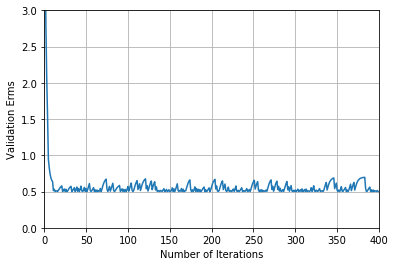

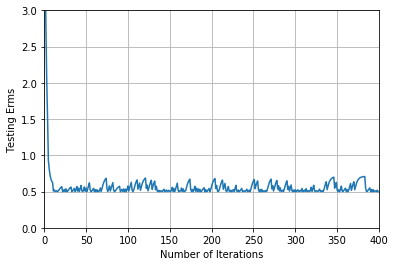

In [161]:
#Running Linear Regression on Human COncatenation Dataset
runLinearRegression('Human','Feature Concatenation',concatTrainingData,concatRawData,concatValidationData
                    ,concatTestData,concatTrainingTarget,concatValidationTarget,concatTestDataAct)

In [162]:

#Feature Subtraction
subRawTarget,subRawData = generateData(subtractionFeatures,False)
subTrainingTarget,subTrainingData=createTrainingDataset(subRawTarget,subRawData)
subValidationTarget,subValidationData=createValidationDataset(subRawTarget,subRawData,subTrainingTarget)
subTestDataAct,subTestData=createTestingDataset(subRawTarget,subRawData,subTrainingTarget,subValidationTarget)

TrainingTarget Data: (1266,)
Training Data: (9, 1266)
ValidationTarget Data: (158,)
Validation Data: (9, 158)
TestingTarget Data: (157,)
Testing Data: (9, 157)


/anaconda3/envs/ML_Tensor_Keras/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


(10, 9)
(9, 9)
(1266, 10)
(158, 10)
(157, 10)
----------Gradient Descent Solution--------------------
UBITname      = APURBAMA
Person Number = 50288705
----------------------------------------------------
------------------Feature Subtraction----Human Dataset------------------
------------------Linear Regression Model----------------------
M = 10 
Lambda  = 2
eta=0.01
E_rms Training   = 0.50005
E_rms Validation = 0.49934
E_rms Testing    = 0.49944
Testing Accuracy    = 54.77707


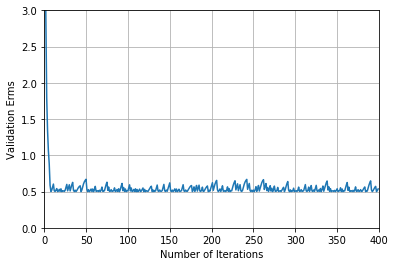

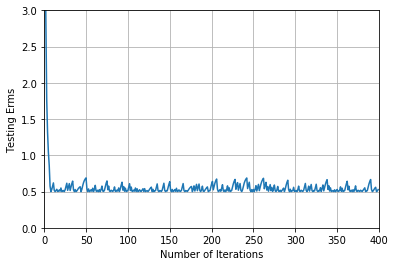

In [163]:
#Running Linear Regression on Human Subtraction Dataset
runLinearRegression('Human','Feature Subtraction',subTrainingData,subRawData,subValidationData
                    ,subTestData,subTrainingTarget,subValidationTarget,subTestDataAct)

In [175]:
#GSC Feature Generation
gscConcatFeatures,gscSubtractionFeatures=generateFeatureData(IsConcat,gscFeatureFile,gscSamePairFile
                                  ,gscDiffPairFile,gscDataSampleSize,True)


Feature Concatenation:(100000, 1027)
Feature Subtraction:(100000, 513)


In [176]:
#GSC Feature Concatenation
gscConcatRawTarget,gscConcatRawData = generateData(gscConcatFeatures,IsConcat)
gscConcatTrainingTarget,gscConcatTrainingData=createTrainingDataset(gscConcatRawTarget,gscConcatRawData)
gscConcatValidationTarget,gscConcatValidationData=createValidationDataset(gscConcatRawTarget,gscConcatRawData,gscConcatTrainingTarget)
gscConcatTestDataAct,gscConcatTestData=createTestingDataset(gscConcatRawTarget,gscConcatRawData,gscConcatTrainingTarget,gscConcatValidationTarget)

TrainingTarget Data: (80000,)
Training Data: (1017, 80000)
ValidationTarget Data: (9999,)
Validation Data: (1017, 9999)
TestingTarget Data: (9999,)
Testing Data: (1017, 9999)


/anaconda3/envs/ML_Tensor_Keras/lib/python3.6/site-packages/ipykernel_launcher.py:12: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if sys.path[0] == '':


(10, 1017)
(1017, 1017)
(80000, 10)
(9999, 10)
(9999, 10)
----------Gradient Descent Solution--------------------
UBITname      = APURBAMA
Person Number = 50288705
----------------------------------------------------
------------------Feature Concatenation----GSC Dataset------------------
------------------Linear Regression Model----------------------
M = 10 
Lambda  = 2
eta=0.01
E_rms Training   = 0.54827
E_rms Validation = 0.54708
E_rms Testing    = 0.54853
Testing Accuracy    = 52.74527


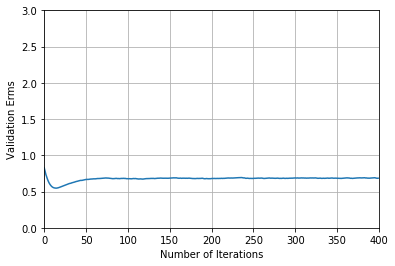

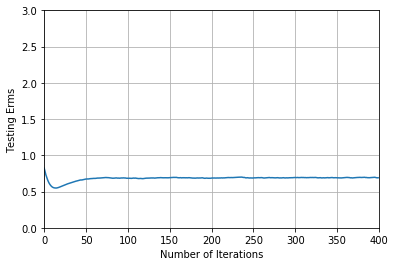

In [177]:
#Running Linear Regression on GSC Concatenation Dataset
runLinearRegression('GSC','Feature Concatenation',gscConcatTrainingData,gscConcatRawData,gscConcatValidationData
                    ,gscConcatTestData,gscConcatTrainingTarget,gscConcatValidationTarget,gscConcatTestDataAct)

In [178]:
#GSC Feature Subtraction
gscSubRawTarget,gscSubRawData = generateData(gscSubtractionFeatures,False)
gscSubTrainingTarget,gscSubTrainingData=createTrainingDataset(gscSubRawTarget,gscSubRawData)
gscSubValidationTarget,gscSubValidationData=createValidationDataset(gscSubRawTarget,gscSubRawData,gscSubTrainingTarget)
gscSubTestDataAct,gscSubTestData=createTestingDataset(gscSubRawTarget,gscSubRawData,gscSubTrainingTarget,gscSubValidationTarget)

TrainingTarget Data: (80000,)
Training Data: (509, 80000)
ValidationTarget Data: (9999,)
Validation Data: (509, 9999)
TestingTarget Data: (9999,)
Testing Data: (509, 9999)


/anaconda3/envs/ML_Tensor_Keras/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


(10, 509)
(509, 509)
(80000, 10)
(9999, 10)
(9999, 10)
----------Gradient Descent Solution--------------------
UBITname      = APURBAMA
Person Number = 50288705
----------------------------------------------------
------------------Feature Subtraction----GSC Dataset------------------
------------------Linear Regression Model----------------------
M = 10 
Lambda  = 2
eta=0.01
E_rms Training   = 0.49773
E_rms Validation = 0.49613
E_rms Testing    = 0.49712
Testing Accuracy    = 59.78598


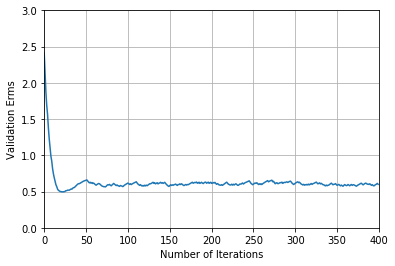

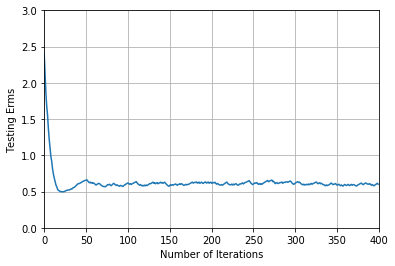

In [179]:
#Running Linear Regression on GSC Subtraction Dataset
runLinearRegression('GSC','Feature Subtraction',gscSubTrainingData,gscSubRawData,gscSubValidationData
                    ,gscSubTestData,gscSubTrainingTarget,gscSubValidationTarget,gscSubTestDataAct)

In [167]:
def generateErmsGraph(L_Erms_Test,M_List,method):
    plt.axis([0, 400, 0, 3])
    plt.ylabel(str(method)+' Erms')
    plt.xlabel('Number of Iterations')
    plt.grid(True)
    
    plt.plot(M_List,L_Erms_Test)
    plt.show()